In [9]:
import pandas as pd
import numpy as np
import os
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  dftrain = pd.read_csv(r'C:\Users\ASUS\Downloads\train_av.csv')

In [118]:
dftrain = pd.read_csv(r'C:\Users\ASUS\Downloads\train_av.csv')

In [93]:
dftrain.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [96]:
print(dftrain.isnull().values.any())

True


In [106]:
dftrain = pd.read_csv(r'C:\Users\ASUS\Downloads\train_av.csv')

In [107]:
dftrain.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [108]:
dftest = pd.read_csv(r'C:\Users\ASUS\Downloads\test_av.csv')

In [109]:
dftest.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [110]:
print(dftest.isnull().sum())

id       0
tweet    0
dtype: int64


In [102]:
dftrain.shape

(162980, 2)

In [103]:
dftest.shape

(17197, 2)

In [111]:
cnt1 = len(dftrain[dftrain['label']==1])
cnt0 = len(dftrain[dftrain['label']==0])
pct0 = cnt0/(cnt1+cnt0)
print('percent 0',round(pct0*100,2))
pct1 = cnt1/(cnt0+cnt1)
print('percent 1',round(pct1*100,2))

percent 0 92.99
percent 1 7.01


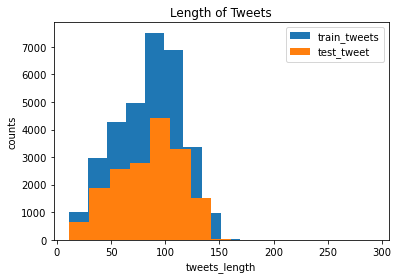

In [112]:
trainlen = dftrain['tweet'].str.len()
testlen = dftest['tweet'].str.len()
plt.hist(trainlen,label ='train_tweets',bins=15)
plt.hist(testlen,label = 'test_tweet',bins=15)
plt.title('Length of Tweets')
plt.xlabel('tweets_length')
plt.ylabel('counts')
plt.legend()
plt.show()

In [114]:
def word_count(sentence):
    return len(sentence.split())
    
dftrain['word count'] = dftrain['tweet'].apply(word_count)
dftrain.head(3)

,id,label,tweet,word count
0,1,0,@user when a father is dysfunctional and is s...,18
1,2,0,@user @user thanks for #lyft credit i can't us...,19
2,3,0,bihday your majesty,3


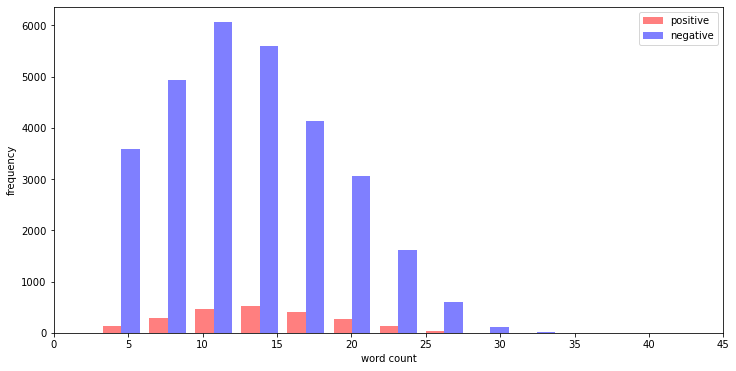

In [115]:
x = dftrain['word count'][dftrain.label == 1]
y = dftrain['word count'][dftrain.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')


In [87]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer #Load #training dataset to Pandas and preview the top rows.
from collections import Counter

In [66]:
all_words = []
for line in list(dftrain['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
Counter(all_words).most_common(10)   

[('@user', 17291),
 ('the', 10065),
 ('to', 9768),
 ('a', 6261),
 ('i', 5655),
 ('you', 4949),
 ('and', 4831),
 ('in', 4570),
 ('for', 4435),
 ('of', 4152)]

In [67]:
data = dftrain.append(dftest,ignore_index=True)

In [68]:
data.head()

,id,label,tweet,word count
0,1,0.0,@user when a father is dysfunctional and is s...,18.0
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0
2,3,0.0,bihday your majesty,3.0
3,4,0.0,#model i love u take with u all the time in ...,14.0
4,5,0.0,factsguide: society now #motivation,4.0


In [69]:
# helper function to clean tweets
'''def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet'''

"def processTweet(tweet):\n    # Remove HTML special entities (e.g. &amp;)\n    tweet = re.sub(r'\\&\\w*;', '', tweet)\n    #Convert @username to AT_USER\n    tweet = re.sub('@[^\\s]+','',tweet)\n    # Remove tickers\n    tweet = re.sub(r'\\$\\w*', '', tweet)\n    # To lowercase\n    tweet = tweet.lower()\n    # Remove hyperlinks\n    tweet = re.sub(r'https?:\\/\\/.*\\/\\w*', '', tweet)\n    # Remove hashtags\n    tweet = re.sub(r'#\\w*', '', tweet)\n    # Remove Punctuation and split 's, 't, 've with a space for filter\n    #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)\n    # Remove words with 2 or fewer letters\n    tweet = re.sub(r'\x08\\w{1,2}\x08', '', tweet)\n    # Remove whitespace (including new line characters)\n    tweet = re.sub(r'\\s\\s+', ' ', tweet)\n    # Remove single space remaining at the front of the tweet.\n    tweet = tweet.lstrip(' ') \n    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:\n    tweet = ''.join(c for c 

In [70]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

In [71]:
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*") 
data.head()

,id,label,tweet,word count,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,18.0,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,3.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,14.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,4.0,factsguide: society now #motivation


In [72]:
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
data.head(10)

,id,label,tweet,word count,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,18.0,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,19.0,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,3.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,14.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,4.0,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,19.0,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,11.0,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,21.0,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,11.0,we won love the land #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,10.0,welcome here i m it s so #gr


In [73]:
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [74]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [75]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [76]:
data['tidy_tweet']=tokenized_tweet

In [77]:
data['tidy_tweet'].head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

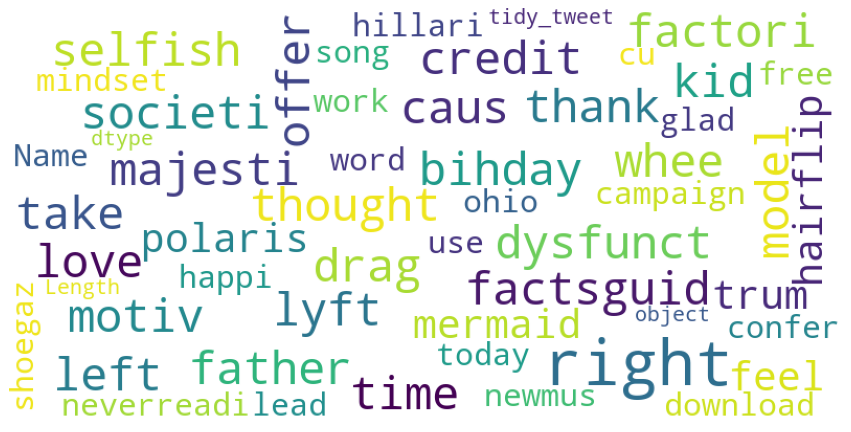

In [79]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(data['tidy_tweet'])

In [81]:
normal_words =' '.join([str(text) for text in data['tidy_tweet'][data['label'] == 0]]) 

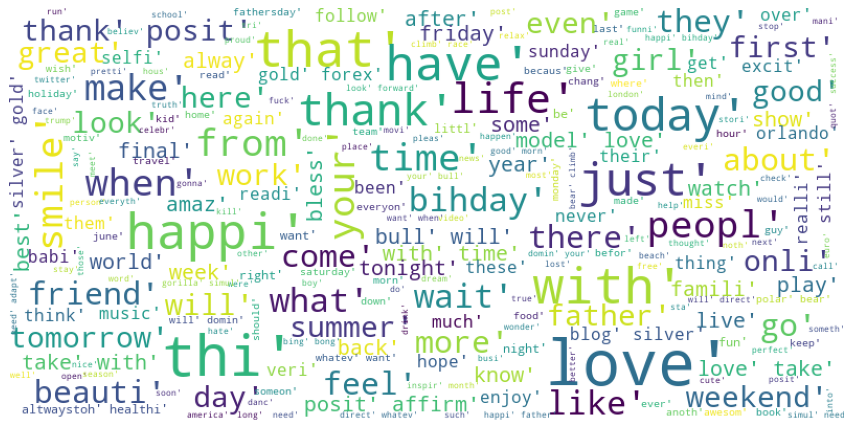

In [82]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5 #chosen a andom by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(normal_words)